In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import numpy as np
import scipy.io
import cPickle as pickle

from scipy.ndimage.interpolation import zoom
import scipy.io
from time import time

sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import features, evaluation

from nolearn.lasagne import objective
from lasagne.layers import get_all_params

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
base_path = '/home/michael/projects/engaged_hackathon_data/'

savedir = base_path + 'detection/train_test_patches/'
spec_path = base_path + 'detection/spectrograms/'
one_minute_path = base_path + 'raw_data/one_minute_files/'

split = scipy.io.loadmat(savedir + 'split.mat')
split['test_files'] = [xx.strip() for xx in split['test_files']]

## Loading the network 

In [18]:
# I need to redefine this reg objective due to the 
# pickling, will see if I can avoid doing this...
def regularization_objective(layers, lambda1=0., lambda2=0., *args, **kwargs):
    # default loss
    losses = objective(layers, *args, **kwargs)
    # get the layers' weights, but only those that should be regularized
    # (i.e. not the biases)
    weights = get_all_params(layers[-1], regularizable=True)
    # sum of absolute weights for L1
    sum_abs_weights = sum([abs(w).sum() for w in weights])
    # sum of squared weights for L2
    sum_squared_weights = sum([(w ** 2).sum() for w in weights])
    # add weights to regular loss
    losses += lambda1 * sum_abs_weights + lambda2 * sum_squared_weights
    return losses

modeldir = '/home/michael/projects/engaged_hackathon_data/detection/models/'
net = pickle.load(open(modeldir + 'cnn_' + 'full' + '.pkl'))

## Classifying all the test files

In [31]:
results = []

for count, fname in enumerate(split['test_files']):

    # load the spec and gt
    spec = scipy.io.loadmat(spec_path + fname + '_spec_128.mat')['spectrogram']
    gt = scipy.io.loadmat(one_minute_path + '/detection_challenge/' + fname + '.mat')

    # convert the labels to the sampling rate of the spectrogram
    zoom_factor = float(spec.shape[1]) / float(gt['biotic'][0].shape[0])
    gt_biotic = zoom(gt['biotic'][0], zoom_factor).astype(float)

    # extracting the patches
    patches = features.extract_1d_patches(spec, range(spec.shape[1]), 9)
    S = patches.shape
    patches = patches.reshape((S[0], 1, S[1], S[2])).astype(np.float32)
    
    #  classify
    pred_y = net.predict_proba(patches)[:, 1]
    factor = gt_biotic.shape[0] / float(pred_y.shape[0])
    pred_y_rescaled = zoom(pred_y, factor)
    
    results.append(
        {'gt': gt_biotic, 
         'pred': pred_y_rescaled,
         'accuracy': accuracy_score(gt_biotic, pred_y>0.5),
         'normalised_accuracy': evaluation.normalised_accuracy(gt_biotic, pred_y>0.5),
         'length': evaluation.eval_seconds(gt_biotic, pred_y, 60.0)
        })
    
    if count % 10 == 0:
        print count,

0 10 20 30 40 50 60 70 80 90 100


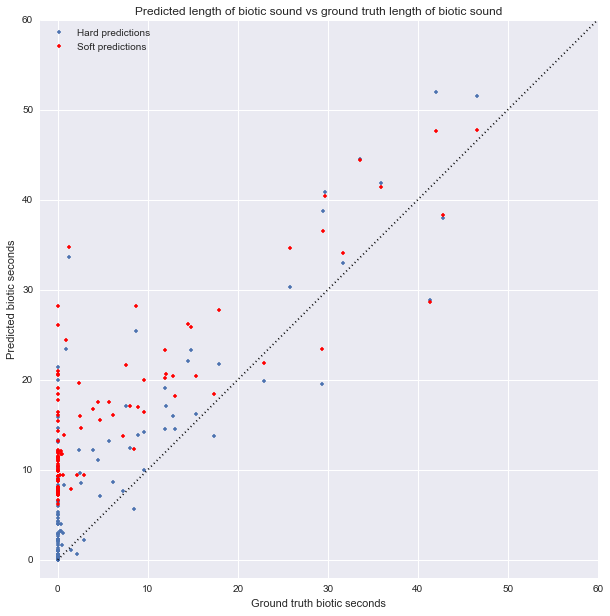

In [32]:
bi_s = np.array([res['length']['biotic'] for res in results])
pred_s = np.array([res['length']['predicted'] for res in results])
pred_hard_s = np.array([res['length']['predicted_hard'] for res in results])

plt.figure(figsize=(10, 10))

plt.plot(bi_s, pred_hard_s, '.', label='Hard predictions')
plt.plot(bi_s, pred_s, '.r', label='Soft predictions')
plt.xlabel('Ground truth biotic seconds')
plt.ylabel('Predicted biotic seconds')
plt.xlim(-2, 60)
plt.ylim(-2, 60)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot([0, 60], [0, 60], 'k:')
plt.legend(loc='best')
plt.title("Predicted length of biotic sound vs ground truth length of biotic sound")

In [36]:
# Now augmenting this data by taking snippets from the files...
# doing the same but for subsets of files...
from sklearn.cross_validation import train_test_split

# here do a train/test split
num_test_files = len(results)
train_files, test_files = \
    train_test_split(range(num_test_files), test_size=0.2, random_state=10)

# first put all predictions together 
gt_train = np.hstack([results[idx]['gt'] for idx in train_files])
gt_test = np.hstack([results[idx]['gt'] for idx in test_files])
pred_train = np.hstack([results[idx]['pred'] for idx in train_files])
pred_test = np.hstack([results[idx]['pred'] for idx in test_files])

sr = 24000  # magic number, sorry

# now extract all the predictions
num_snips = 100
test_summaries, train_summaries = [], []
# files_used = []

for count in range(num_snips):
        
    # extract training snippet
    this_snip_length = np.random.randint(1, gt_train.shape[0])
    start_loc = np.random.randint(0, gt_train.shape[0] - this_snip_length)
    train_gt_snip = gt_train[start_loc:start_loc+this_snip_length]
    train_pred_snip = pred_train[start_loc:start_loc+this_snip_length]
    
    # now add the summaries to the summary list...
    train_summaries.append(evaluation.eval_seconds(gt_snip, pred_snip, gt_snip.shape[0] / float(sr)))
    
    # extract test snippet
    this_snip_length = np.random.randint(1, gt_train.shape[0])
    start_loc = np.random.randint(0, gt_train.shape[0] - this_snip_length)
    test_gt_snip = gt_test[start_loc:start_loc+this_snip_length]
    test_pred_snip = pred_test[start_loc:start_loc+this_snip_length]
    
    # now add the summaries to the summary list...
    test_summaries.append(evaluation.eval_seconds(gt_snip, pred_snip, gt_snip.shape[0] / float(sr)))

    if count % 100 == 0:
        print count,

0


In [37]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor

feats = ['predicted', 'predicted_hard', 'soft_variance', 'soft_binning']

all_reg_gts = []
all_reg_preds = []
all_reg_simple = []
all_lengths = []

# creating the full X and Y sets
train_and_test = {}

for summaries, name in ((train_summaries, 'train'), (test_summaries, 'test')):
    X, y, lens = [], [], []
    
    for summ in summaries:
        y.append(summ['biotic'])    
        X.append(np.hstack([summ[feat] for feat in feats]))
        lens.append(summ['length'])  # need to know the lengths for % error

    X = np.vstack(X)
    y = np.hstack(y)
    lens = np.hstack(lens)
    
    train_and_test[name] = (X, y, lens)
    print X.shape, y.shape, lens.shape

(100, 13) (100,) (100,)
(100, 13) (100,) (100,)


In [ ]:
# # split test set into eg_train and reg_test
# files_used = np.array(files_used)
# train_files, test_files = \
#     train_test_split(np.unique(files_used), test_size=0.2, random_state=seed)

# test_file_idxs = np.array(
#     [count for count, xx in enumerate(files_used) if xx in test_files])
# train_file_idxs = np.array(
#     [count for count, xx in enumerate(files_used) if xx in train_files])

reg = {}
reg['test_X'] = X[test_file_idxs, :]
reg['test_y'] = y[test_file_idxs]
reg['train_X'] = X[train_file_idxs, :]
reg['train_y'] = y[train_file_idxs]
reg['test_lengths'] = lens[test_file_idxs]  # only need the test lengths, as used for reporting the error

# for key, val in reg.iteritems():
#     print key, val.shape, val.dtype
# train a forest on the stats from reg_train
rf = RandomForestRegressor(n_estimators=50)
rf.fit(reg['train_X'], reg['train_y'])

# test on the test set...
y_pred = rf.predict(reg['test_X'])

all_reg_gts.append(reg['test_y'])
all_reg_preds.append(y_pred)
all_reg_simple.append(reg['test_X'][:, 1].ravel())
all_lengths.append(reg['test_lengths'])

In [ ]:

from sklearn import metrics

def plot_reg(gt, pred, title=""):

    sns.regplot(x=gt, y=pred, x_jitter=.0, y_jitter=.0, line_kws={'color': 'r'});

    plt.xlim(-2, 60)
    plt.ylim(-2, 60)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.plot([0, 60], [0, 60], 'k:')
    
    plt.xlabel('Ground truth biotic seconds')
    plt.ylabel('Predicted biotic seconds')
    
    lens = np.hstack(all_lengths).astype(np.float32) / sr # in seconds
    mean_per_error = (np.abs(gt-pred) / lens).mean() * 100
    print mean_per_error
    print lens[:100]
    
    plt.title(title + " (Error = %0.2f"  % mean_per_error + " %)")


plt.figure(figsize=(15, 10))

print np.hstack(all_reg_gts).shape
print np.array(all_reg_preds).shape

plt.subplot(121)
plot_reg(np.hstack(all_reg_gts), np.hstack(all_reg_simple), 'Summing CNN predictions')
plt.subplot(122)
plot_reg(np.hstack(all_reg_gts), np.hstack(all_reg_preds), 'Learned forest')
